## Join the Duet Server the Data Owner 1 connected to

In [1]:
import syft as sy
duet1 = sy.duet("52b35ffe2dd5c09b84d5a1376105e996")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 15dea33d37950ffa541c77f0fd2312f7

♫♫♫ > ...waiting for partner to connect...


C:\Users\dylan\anaconda3\envs\new_pysyft\lib\site-packages\aiortc\rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
C:\Users\dylan\anaconda3\envs\new_pysyft\lib\site-packages\aiortc\rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


## Join the Duet Server the Data Owner 2 connected to

In [2]:
duet2 = sy.duet("0355643b0357fbf356acabe406031185")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 48ef95f5e1e047ff5316399467698eb2

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


In [3]:
duet1.store.pandas

,ID,Tags,Description,object_type
0,<UID: 4f3c02da73354c59999192d3781a74eb>,[DO1 training X data],number of samples and features,<class 'torch.Tensor'>
1,<UID: 8c5b01dc4bf34fb8aa5f12404a2fc7f5>,[DO1 training y data],number of samples and features,<class 'torch.Tensor'>
2,<UID: 0d042c4a05544d5da25c9303fcf34fe4>,[size of DO1's training data],size of DO1's training data,<class 'syft.lib.python.Int'>


In [4]:
duet2.store.pandas

,ID,Tags,Description,object_type
0,<UID: 2501dff885624096a2e9097d9735876d>,[DO2 training X data],number of samples and features,<class 'torch.Tensor'>
1,<UID: b6c88f867fda4b1484666dbc75151e6c>,[DO2 training y data],number of samples and features,<class 'torch.Tensor'>
2,<UID: d15b056a2fa74a2b83c3ce9cc0cc1741>,[size of DO2's training data],size of DO2's training data,<class 'syft.lib.python.Int'>


## Modelling

In [5]:
data1_ptr = duet1.store[0]
target1_ptr = duet1.store[1]
train_size_1_ptr = duet1.store[2]

data2_ptr = duet2.store[0]
target2_ptr = duet2.store[1]
train_size_2_ptr = duet2.store[2]

print(data1_ptr)
print(target1_ptr)
print(train_size_1_ptr)
print(data2_ptr)
print(target2_ptr)
print(train_size_2_ptr)

### Create Base Model

In [6]:
#import torch
import torch.nn.functional as F
import torch.nn as nn 
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance
from scipy import stats
from tqdm.notebook import tqdm
import torch as th
import torch
import numpy as np

In [7]:
in_dim = 39
out_dim = 1

In [8]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        
        self.layer_1 = self.torch_ref.nn.Linear(39, 31)
        self.layer_out = self.torch_ref.nn.Linear(31, 1)
        # Define proportion or neurons to dropout
        self.dropout_1 = self.torch_ref.nn.Dropout(0.12409392594394411)
        self.relu = self.torch_ref.nn.ReLU()
    
    def forward(self, inputs):
        x = self.dropout_1(self.relu(self.layer_1(inputs)))
        x = self.layer_out(x)

        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.layer_out(x)

        return (x)

### Training

Set arguments for training

In [9]:
# Lets define a few settings which are from the original MNIST example command-line args
args = {
    "batch_size": 1000,
    "log_batch_size":10,
    "test_batch_size": 1,
    "epochs": 25,
    "lr": 6.888528294546944e-05,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": True,
    "threads":0,
}

##### Custom PyTorch Dataset Class for batch loading

In [10]:
class DatasetFromPointer(torch.utils.data.Dataset):
    def __init__(self, 
                 X_tensorpointer,
                 y_tensorpointer,
                 datanum_pointer,
                 ):
        super(DatasetFromPointer, self).__init__()
        self.X_tensorpointer = X_tensorpointer
        self.y_tensorpointer = y_tensorpointer
        self.datanum_pointer = datanum_pointer

    def __getitem__(self, index):
        input = self.X_tensorpointer[index]
        target = self.y_tensorpointer[index]
        return input, target

    def __len__(self):
        return self.datanum_pointer.get(
        request_block=True,
        reason="To write the training loop",
        timeout_secs=30,
        delete_obj=False,
    )
        
def batch_idx_fn(batch):
    return batch[0]

In [11]:
train_set_1 = DatasetFromPointer(data1_ptr, target1_ptr, train_size_1_ptr)

training_data_loader_1 = DataLoader(dataset=train_set_1, 
                                  num_workers=args["threads"], batch_size=args["batch_size"], shuffle=True,
                                  collate_fn=batch_idx_fn)

In [12]:
# normally we would not necessarily know the length of a remote dataset so lets ask for it
# so we can pass that to our training loop and know when to stop
def get_train_length(train_data_ptr):
    train_data_length = len(train_data_ptr)
    return train_data_length

try:
    if train_data_length is None:
        train_data_length = get_train_length(data1_ptr)
except NameError:
        train_data_length = get_train_length(data1_ptr)

print(f"Training Dataset size is: {train_data_length}")

Training Dataset size is: 244085


In [13]:
# normally we would not necessarily know the length of a remote dataset so lets ask for it
# so we can pass that to our training loop and know when to stop
def get_train_loader_length(training_data_loader):
    train_data_loader_length = len(training_data_loader)
    return train_data_loader_length

try:
    if train_data_loader_length is None:
        train_data_loader_length = get_train_length(training_data_loader_1)
except NameError:
        train_data_loader_length = get_train_length(training_data_loader_1)

print(f"Training Data loader size is: {train_data_loader_length}")

Training Data loader size is: 245


##### Try different training loop functions

Below is a basic loop from an Iris classifier example from an OpenMined course: https://courses.openmined.org/courses/foundations-of-private-computation/5b4beea5-9e95-42a5-9b8e-c5222386314a/2cd76fa7-bfd8-42cf-8913-19b1536ddc87

**Also might be worth going through for more examples of how to use Duet!**

In [14]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    model.train()

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        loss = torch_ref.nn.functional.poisson_nll_loss(output, target_ptr, log_input= True, full= True)   

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress",
            request_block=True,
            timeout_secs=5,
        )

        print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

A variant I've come up with which **should** work with batch loaders

In [16]:
def train_v2(iterations, model, torch_ref, optim, train_loader):

    model.train()

    losses = []

    for i in range(iterations):

        for batch_idx, data in enumerate(train_loader):
            data_ptr, target_ptr = data[0], data[1]

            optim.zero_grad()

            output = model(data_ptr)

            loss = torch_ref.nn.functional.poisson_nll_loss(output, target_ptr, log_input= True, full= True)   

            loss_item = loss.item()

            loss_value = loss_item.get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5,
            )

            losses.append(loss_value)

            loss.backward()

            optim.step()
            
        print("Epoch", i, "loss", loss_value)

    return losses

An adaption of the training loop I initially used in the `0.2.9` use case, but should now work with Duet and batches

In [17]:
def train_fl(model, torch_ref, optim, train_loader, epochs):

    losses = []

    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):

        # Training

        model.train()

        train_epoch_loss = 0

        for batch_idx, data in enumerate(train_loader):
            
            data_ptr, target_ptr = data[0], data[1]

            optim.zero_grad()

            output = model(data_ptr)

            loss = torch_ref.nn.functional.poisson_nll_loss(output, target_ptr, log_input= True, full= True)   

            loss_item = loss.item()
            
            loss_value = loss_item.get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5,
            )

            #print("Epoch", i, "loss", loss_value)

            losses.append(loss_value)

            loss.backward()

            optim.step()

            train_epoch_loss += loss_value

        losses.append(train_epoch_loss/train_data_loader_length)
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/train_data_loader_length:.5f}')

    return losses

Similarly, an adaption of an OpenMined course training loop I found: https://github.com/OpenMined/courses/tree/foundations-of-private-computation/federated-learning/duet_mnist

In [18]:
def train_MNIST(model, torch_ref, train_loader, optimizer, epoch, args, train_data_length, duet_server):
    # + 0.5 lets us math.ceil without the import
    train_batches = round((train_data_length / args["batch_size"]) + 0.5)
    print(f"> Running train in {train_batches} batches")
    if model.is_local:
        print("Training requires remote model")
        return

    model.train()

    for batch_idx, data in enumerate(train_loader):
        data_ptr, target_ptr = data[0], data[1]
        optimizer.zero_grad()
        output = model(data_ptr)
        loss = torch_ref.nn.functional.poisson_nll_loss(output, target_ptr, log_input= True, full= True)   
        loss.backward()
        optimizer.step()
        loss_item = loss.item()
        train_loss = duet_server.python.Float(0)  # create a remote Float we can use for summation
        train_loss += loss_item
        
        if batch_idx % args["log_interval"] == 0:
        
            local_loss = None
            
            local_loss = loss_item.get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5
            )

            if local_loss is not None:
                print("Train Epoch: {} {} {:.4}".format(epoch, batch_idx, local_loss))

            else:
                print("Train Epoch: {} {} ?".format(epoch, batch_idx))

        if batch_idx >= train_batches - 1:
            print("batch_idx >= train_batches, breaking")
            break
        
        if args["dry_run"]:
            break

#### Send one copy of the model to each data owner or client and train them remotely one by one

Create a local model

In [30]:
base_model = SyNet(torch)

Send the model to DO1

In [31]:
remote_model1 = base_model.send(duet1)

Create alias for DO1's instance of torch called `remote_torch1` so we can refer to the local torch as `torch` and any operation we want to do remotely as `remote_torch1`. Remember, the return values from `remote_torch1` are `Pointers`, not the real objects. They mostly act the same when using them with other `Pointers` but you can't mix them with local torch objects.

In [32]:
remote_torch1 = duet1.torch

In [33]:
# lets ask to see if our Data Owner has CUDA
has_cuda = False
has_cuda_ptr = remote_torch1.cuda.is_available()
has_cuda = bool(has_cuda_ptr.get(
    request_block=True,
    reason="To run test and inference locally",
    timeout_secs=5,  # change to something slower
))
print(has_cuda)

False


In [34]:
use_cuda = not args["no_cuda"] and has_cuda
# now we can set the seed
remote_torch1.manual_seed(args["seed"])

device = remote_torch1.device("cuda" if use_cuda else "cpu")
print(f"Data Owner 1 device is {device.type.get()}")

Data Owner 1 device is cpu


In [35]:
# if we have CUDA lets send our model to the GPU
if has_cuda:
    base_model.cuda(device)
else:
    base_model.cpu()

In [36]:
# The DO has kindly let us initialise a DataLoader for their training set
train_kwargs = {
    "batch_size": args["batch_size"],
}
#train_data_ptr = duet1.store[0]
#train_loader_ptr1 = remote_torch1.utils.data.DataLoader(train_dataset_ptr1,**train_kwargs, shuffle=False)
#train_loader_ptr1 = remote_torch1.utils.data.DataLoader(data1_ptr,**train_kwargs, shuffle=False)

In [37]:
params = remote_model1.parameters()

In [38]:
optim1 = remote_torch1.optim.Adam(params=params, lr=0.01)

In [39]:
scheduler1 = remote_torch1.optim.lr_scheduler.StepLR(optim1, step_size=1, gamma=args["gamma"])

In [40]:
iteration = 25
#losses = train(iteration, remote_model1, remote_torch1, optim1, data1_ptr, target1_ptr)
losses = train_v2(iteration, remote_model1, remote_torch1, optim1, training_data_loader_1)
#losses = train_fl(remote_model1, remote_torch1, optim1, training_data_loader_1, 25)

KeyboardInterrupt: 

This is how the MNIST example training loop gets executed

In [30]:
import time

#args["dry_run"] = True  # comment to do a full train
print("Starting Training")
for epoch in range(1, args["epochs"] + 1):
    epoch_start = time.time()
    print(f"Epoch: {epoch}")
    # remote training on model with remote_torch
    train_MNIST(remote_model1, remote_torch1, training_data_loader_1, optim1, epoch, args, train_data_length, duet1)
    # local testing on model with local torch
    #test_local(model, torch, test_loader, test_data_length)
    #scheduler1.step()
    epoch_end = time.time()
    print(f"Epoch time: {int(epoch_end - epoch_start)} seconds")
    if args["dry_run"]:
        break
print("Finished Training")

Starting Training
Epoch: 1
> Running train in 245 batches
Train Epoch: 1 0 ?


KeyboardInterrupt: 

Training loop from SuperResoulation image example which is where customer Dataset Class came from: https://github.com/OpenMined/PySyft/blob/0.5.0/packages/syft/examples/duet/super_resolution/SuperResolution_Syft_Data_Scientist.ipynb

In [30]:
for epoch in range(args["epochs"]):
    
    remote_model1.train()
    
    epoch_loss = 0
    
    for batch_idx, data_pointers in enumerate(training_data_loader_1):

        optim1.zero_grad()

        data_ptr, target_ptr = data_pointers[0], data_pointers[1]
        #data_ptr_reshape = remote_torch.unsqueeze(remote_torch.unsqueeze(data_ptr, 0), 0)
        #target_ptr_reshape = remote_torch.unsqueeze(remote_torch.unsqueeze(target_ptr, 0), 0)
       
        output_ptr = remote_model1(data_ptr)
        
        loss = remote_torch1.nn.functional.poisson_nll_loss(output_ptr, target_ptr, log_input= True, full= True)   
        
        loss.backward()
        
        optim1.step()

        if batch_idx % args["log_batch_size"] == 0:
            loss_item = loss.item().get(
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=3,
                delete_obj=False,
                verbose=False
                )
            print(f"epoch {epoch}, batch_idx {batch_idx}, loss {loss_item}")

        if args["dry_run"]:
            break

epoch 0, batch_idx 0, loss 1.0572233200073242


This used the "basic" Iris training loop **WITHOUT** batches, but does seem to perform well

Text(0.5, 0, 'iteration')

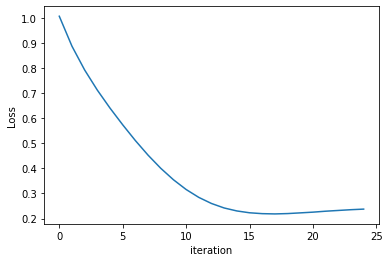

In [110]:
import matplotlib.pyplot as plt
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

Train on Data Owner 2 data

In [25]:
remote_model2 = base_model.send(duet2)

In [26]:
remote_torch2 = duet2.torch
params = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params, lr=0.1)

In [27]:
iteration = 25
losses = train(iteration, remote_model2, remote_torch2, optim2, data2_ptr, target2_ptr)

Epoch 0 loss 0.866819441318512
Epoch 1 loss 0.2198343127965927
Epoch 2 loss 0.34583476185798645
Epoch 3 loss 0.38866788148880005
Epoch 4 loss 0.36773285269737244
Epoch 5 loss 0.31869301199913025
Epoch 6 loss 0.26128965616226196
Epoch 7 loss 0.2231149971485138
Epoch 8 loss 0.2449231892824173
Epoch 9 loss 0.27834591269493103
Epoch 10 loss 0.2464400678873062
Epoch 11 loss 0.22350020706653595
Epoch 12 loss 0.22525842487812042
Epoch 13 loss 0.23436260223388672
Epoch 14 loss 0.24199296534061432
Epoch 15 loss 0.24152319133281708
Epoch 16 loss 0.23684728145599365
Epoch 17 loss 0.22808432579040527
Epoch 18 loss 0.22101826965808868
Epoch 19 loss 0.21924427151679993
Epoch 20 loss 0.22245953977108002
Epoch 21 loss 0.2273198962211609
Epoch 22 loss 0.22881029546260834
Epoch 23 loss 0.22510860860347748
Epoch 24 loss 0.22009003162384033


### Averaging Model Updates

Ideally, there will be a coordinator server with a secure aggreagtor who will get the model updates from different clients and make an aggregation. For the case of simplicity, in this example we will make the Data Sceintist server work as the coordinator.

### Little sanity check!

In [28]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

print("Base Model parameters:")
print(base_model.parameters())
print()

print("Remote model1 parameters:")
print(param1)
print()

print("Remote model2 parameters:")
print(param2)

Base Model parameters:
[Parameter containing:
tensor([[-0.0712,  0.1061, -0.0940,  ..., -0.1477,  0.0342,  0.1121],
        [ 0.1245, -0.0767, -0.0987,  ...,  0.0216, -0.0068,  0.0889],
        [-0.0301, -0.0196, -0.0143,  ..., -0.1531, -0.0409,  0.1513],
        ...,
        [ 0.0561,  0.0076, -0.1051,  ...,  0.0936,  0.1144,  0.1470],
        [ 0.0638,  0.1041, -0.0498,  ...,  0.0147,  0.1587, -0.0028],
        [-0.0095, -0.1080,  0.1125,  ..., -0.1189, -0.1485,  0.1548]],
       requires_grad=True), Parameter containing:
tensor([-0.1205,  0.0079,  0.0367, -0.0509, -0.0069, -0.1523,  0.1282, -0.1140,
         0.0392, -0.1364,  0.1511, -0.0898,  0.0976, -0.1003, -0.1078,  0.0610,
         0.1323,  0.0498,  0.0920, -0.1225,  0.1515,  0.1430,  0.1263, -0.0347,
         0.0997, -0.0430,  0.1285,  0.1190,  0.1389,  0.1224, -0.1436],
       requires_grad=True), Parameter containing:
tensor([[-0.0510,  0.0664, -0.1542, -0.0192, -0.1288,  0.1136, -0.0971,  0.1248,
         -0.1040, -0.0646, 

As you can see, the remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

In [29]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

print(remote_model1_updates)

OrderedDict([('layer_1.weight', tensor([[-0.6705, -0.3303, -0.5241,  ..., -0.6079, -0.3797, -0.2847],
        [-0.4322, -0.6333, -0.6553,  ..., -0.5350, -0.5634, -0.4677],
        [-0.0275, -0.0378,  0.0638,  ..., -0.8276, -0.0713,  0.4437],
        ...,
        [ 0.0864,  0.1229, -0.0402,  ...,  0.3964,  0.4236,  0.4213],
        [-0.4928, -0.4525, -0.6064,  ..., -0.5419, -0.3980, -0.5594],
        [-0.0497, -0.1080, -0.2481,  ..., -0.1189, -0.1485,  0.1548]])), ('layer_1.bias', tensor([-0.5262, -0.5487,  0.1218, -0.4626, -0.3093, -0.7089,  0.0703, -0.6706,
         0.2373, -0.5690, -0.4055, -0.5815,  0.3341, -0.4520, -0.0122, -0.4956,
        -0.4243, -0.5068,  0.3410, -0.6791, -0.2684,  0.1148,  0.4422, -0.5914,
         0.4206, -0.5996,  0.4034,  0.2508,  0.2572, -0.4342, -0.6252])), ('layer_out.weight', tensor([[ 0.3320, -0.4902, -0.0399,  0.2196,  0.4279, -0.4430, -0.0025, -0.4319,
         -0.1332,  0.4993, -0.4381,  0.3149, -0.1719,  0.1590, -0.1019, -0.4788,
         -0.4794, 

In [30]:
remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()

print(remote_model2_updates)

OrderedDict([('layer_1.weight', tensor([[-0.6695, -0.3289, -0.5277,  ..., -0.5887, -0.4030, -0.3813],
        [-0.4322, -0.6333, -0.6553,  ..., -0.5350, -0.5634, -0.4677],
        [-0.0273, -0.0320,  0.0659,  ..., -0.8390, -0.1025,  0.4371],
        ...,
        [ 0.0813,  0.1252, -0.0410,  ...,  0.3924,  0.4068,  0.4236],
        [-0.4928, -0.4525, -0.6064,  ..., -0.5419, -0.3980, -0.5594],
        [-0.5131, -0.1080, -0.3874,  ..., -0.1189, -0.1485,  0.1548]])), ('layer_1.bias', tensor([-0.5267, -0.5487,  0.1208, -0.4643, -0.3141, -0.7089,  0.0686, -0.6706,
         0.2371, -0.5729, -0.4055, -0.5863,  0.3319, -0.4578, -0.0125, -0.4956,
        -0.4243, -0.5068,  0.3385, -0.6791, -0.2732,  0.1152,  0.4409, -0.5914,
         0.4194, -0.5996,  0.4032,  0.2516,  0.2522, -0.4342, -0.6802])), ('layer_out.weight', tensor([[ 0.3328, -0.4902, -0.0424,  0.2189,  0.4296, -0.4430, -0.0008, -0.4319,
         -0.1350,  0.4970, -0.4381,  0.3171, -0.1710,  0.1660, -0.1035, -0.4788,
         -0.4794, 

In [31]:
from collections import OrderedDict

Let's do the aggregation of the weights. In this example, we will just calculate the average of corresponding weights from each model.

In [32]:
avg_updates = OrderedDict()
avg_updates["layer_1.weight"] = (
    remote_model1_updates["layer_1.weight"] + remote_model2_updates["layer_1.weight"]
) / 2
avg_updates["layer_1.bias"] = (
    remote_model1_updates["layer_1.bias"] + remote_model2_updates["layer_1.bias"]
) / 2
avg_updates["layer_out.weight"] = (
    remote_model1_updates["layer_out.weight"] + remote_model2_updates["layer_out.weight"]
) / 2
avg_updates["layer_out.bias"] = (
    remote_model1_updates["layer_out.bias"] + remote_model2_updates["layer_out.bias"]
) / 2

print(avg_updates)

OrderedDict([('layer_1.weight', tensor([[-0.6700, -0.3296, -0.5259,  ..., -0.5983, -0.3913, -0.3330],
        [-0.4322, -0.6333, -0.6553,  ..., -0.5350, -0.5634, -0.4677],
        [-0.0274, -0.0349,  0.0649,  ..., -0.8333, -0.0869,  0.4404],
        ...,
        [ 0.0838,  0.1241, -0.0406,  ...,  0.3944,  0.4152,  0.4224],
        [-0.4928, -0.4525, -0.6064,  ..., -0.5419, -0.3980, -0.5594],
        [-0.2814, -0.1080, -0.3177,  ..., -0.1189, -0.1485,  0.1548]])), ('layer_1.bias', tensor([-0.5264, -0.5487,  0.1213, -0.4635, -0.3117, -0.7089,  0.0695, -0.6706,
         0.2372, -0.5710, -0.4055, -0.5839,  0.3330, -0.4549, -0.0124, -0.4956,
        -0.4243, -0.5068,  0.3398, -0.6791, -0.2708,  0.1150,  0.4416, -0.5914,
         0.4200, -0.5996,  0.4033,  0.2512,  0.2547, -0.4342, -0.6527])), ('layer_out.weight', tensor([[ 0.3324, -0.4902, -0.0411,  0.2192,  0.4288, -0.4430, -0.0017, -0.4319,
         -0.1341,  0.4982, -0.4381,  0.3160, -0.1714,  0.1625, -0.1027, -0.4788,
         -0.4794, 

### Load aggregated weights

In [33]:
combined_model = SyNet(torch)

In [34]:
combined_model.load_state_dict(avg_updates)

In [35]:
del avg_updates, remote_model1_updates, remote_model2_updates

In [36]:
import pandas as pd

In [37]:
df_X_val_0 = pd.read_csv('ETL/X_val_0.csv')
df_y_val_0 = pd.read_csv('ETL/y_val_0.csv')
X_val_0_np = df_X_val_0.to_numpy()
y_val_0_np = df_y_val_0.to_numpy()
X_val_0 = th.from_numpy(X_val_0_np).float()
y_val_0 = th.from_numpy(y_val_0_np).float()

In [38]:
preds = []
with torch.no_grad():
    for i in range(len(X_val_0)):
        sample = X_val_0[i]
        y_hat = combined_model(sample)

        preds.append(y_hat)
preds = [a.squeeze().tolist() for a in preds]
preds_exp=np.exp(preds)

In [39]:
def test_statistics(y_test, y_pred_list_exp):
    mpd = mean_poisson_deviance(y_test, y_pred_list_exp)
    mse = mean_squared_error(y_test, y_pred_list_exp)
    r_square = r2_score(y_test, y_pred_list_exp)
    print("Mean Poisson Deviance :",mpd)
    print("Mean Squared Error :",mse)
    print("R^2 :",r_square)
    print(stats.describe(y_pred_list_exp))

test_statistics(y_val_0, preds_exp)    

Mean Poisson Deviance : 0.33151180815157605
Mean Squared Error : 0.05777559876995095
R^2 : -0.021383390908668254
DescribeResult(nobs=27121, minmax=(0.011241376984763856, 0.4387279399098062), mean=0.06384843144156231, variance=0.0012247683010474955, skewness=1.8565834926461535, kurtosis=6.377252593810198)


In [40]:
preds = []
with torch.no_grad():
    for i in range(len(X_val_0)):
        sample = X_val_0[i]
        y_hat = base_model(sample)

        preds.append(y_hat)
preds = [a.squeeze().tolist() for a in preds]
preds_exp=np.exp(preds)

In [41]:
test_statistics(y_val_0, preds_exp)

Mean Poisson Deviance : 1.6329049567435172
Mean Squared Error : 0.7062302278382026
R^2 : -11.485060133149998
DescribeResult(nobs=27121, minmax=(0.6151756309625854, 1.1147527252579748), mean=0.85664797196814, variance=0.003856103549277682, skewness=0.15042516022297542, kurtosis=-0.04815565053452486)


## Comparison to classical linear regression on centralised data

In [42]:
import torch
import numpy as np

in_dim = 1
out_dim = 1


class ClassicalLR(torch.nn.Module):
    def __init__(self, torch):
        super(ClassicalLR, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.linear(x)
        return x


classical_model = ClassicalLR(torch)

In [43]:
data = torch.FloatTensor(
    np.array([5, 15, 25, 35, 45, 55, 60, 65, 75, 85, 95]).reshape(-1, 1)
)
target = torch.FloatTensor(
    np.array([5, 10, 15, 22, 30, 38, 35, 40, 45, 55, 60]).reshape(-1, 1)
)

In [44]:
def classic_train(iterations, model, torch, optim, data, target, criterion):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss_item = loss.item()

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_item)

        losses.append(loss_item)

        loss.backward()

        optim.step()

    return losses

In [45]:
params = classical_model.parameters()
optim = torch.optim.Adam(params=params, lr=0.1)
criterion = torch.nn.MSELoss()

In [46]:
iteration = 100
losses = classic_train(
    iteration, classical_model, torch, optim, data, target, criterion
)

Epoch 0 loss 187.6728515625
Epoch 10 loss 3.2691376209259033
Epoch 20 loss 6.015904426574707
Epoch 30 loss 6.608091831207275
Epoch 40 loss 4.64339542388916
Epoch 50 loss 3.185041904449463
Epoch 60 loss 3.2361831665039062
Epoch 70 loss 3.117515802383423
Epoch 80 loss 3.0566627979278564
Epoch 90 loss 3.0253264904022217


In [47]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [48]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = classical_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: 10.919013023376465 Ground Truth: 12.0
Prediction: 15.913439750671387 Ground Truth: 15.0
Prediction: 20.2835636138916 Ground Truth: 20.0
Prediction: 31.52102279663086 Ground Truth: 30.0
Prediction: 50.2501220703125 Ground Truth: 50.0
